In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from reservoirpy.nodes import Reservoir, Ridge, ESN
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [124]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EMBEDDING_SIZE = 256  # Taille des embeddings pour tous les inputs
NUM_HEADS = 8
NUM_LAYERS = 4
DROPOUT = 0.1
LEARNING_RATE = 1e-4
EPOCHS = 20

In [103]:
def load_data():
    partOfData = 1
    X_genres = pd.read_csv("../data/train/input_genres_tags_data.csv")
    X_instruments = pd.read_csv("../data/train/input_instruments_tags_data.csv")
    X_moods = pd.read_csv("../data/train/input_moods_tags_data.csv")

    y_genres = pd.read_csv("../data/train/output_genres_tags_data.csv")
    y_instruments = pd.read_csv("../data/train/output_instruments_tags_data.csv")
    y_moods = pd.read_csv("../data/train/output_moods_tags_data.csv")

    # On peut garder seulement une partie des données
    X_genres = X_genres[: int(partOfData * len(X_genres))]
    X_instruments = X_instruments[: int(partOfData * len(X_instruments))]
    X_moods = X_moods[: int(partOfData * len(X_moods))]
    y_genres = y_genres[: int(partOfData * len(y_genres))]
    y_instruments = y_instruments[: int(partOfData * len(y_instruments))]
    y_moods = y_moods[: int(partOfData * len(y_moods))]

    return (X_genres, X_instruments, X_moods), (y_genres, y_instruments, y_moods)


# Ensure the input data is in the correct format
def reshape_input(X):
    if isinstance(X, pd.DataFrame):
        return X.values.reshape(-1, 1, X.shape[1])  # Handles pandas DataFrame
    elif isinstance(X, np.ndarray):
        return X.reshape(-1, 1, X.shape[1])  # Handles numpy ndarray
    else:
        raise ValueError("Input must be a pandas DataFrame or a numpy ndarray")


def format_predictions(predictions):
    # Convert the list to a NumPy array
    predictions_array = np.array(predictions)

    # Reshape the array to 2-dimensional
    predictions_reshaped = predictions_array.reshape(-1, predictions_array.shape[-1])

    return predictions_reshaped

In [104]:
# Charger les données
(X_genres, X_instruments, X_moods), (y_genres, y_instruments, y_moods) = load_data()

# Train-test split
X_genres_train, X_genres_test, y_genres_train, y_genres_test = train_test_split(
    X_genres, y_genres, test_size=0.2, random_state=42
)
X_instruments_train, X_instruments_test, y_instruments_train, y_instruments_test = (
    train_test_split(X_instruments, y_instruments, test_size=0.2, random_state=42)
)
X_moods_train, X_moods_test, y_moods_train, y_moods_test = train_test_split(
    X_moods, y_moods, test_size=0.2, random_state=42
)

In [ ]:
# Préparation des données
X_genres_train = X_genres_train.drop(columns=["ChallengeID"])
X_instruments_train = X_instruments_train.drop(columns=["ChallengeID"])
X_moods_train = X_moods_train.drop(columns=["ChallengeID"])
y_genres_train = y_genres_train.drop(columns=["ChallengeID"])
y_instruments_train = y_instruments_train.drop(columns=["ChallengeID"])
y_moods_train = y_moods_train.drop(columns=["ChallengeID"])

X_genres_test = X_genres_test.drop(columns=["ChallengeID"])
X_instruments_test = X_instruments_test.drop(columns=["ChallengeID"])
X_moods_test = X_moods_test.drop(columns=["ChallengeID"])
y_genres_test = y_genres_test.drop(columns=["ChallengeID"])
y_instruments_test = y_instruments_test.drop(columns=["ChallengeID"])
y_moods_test = y_moods_test.drop(columns=["ChallengeID"])


X_train = np.concatenate([X_genres_train, X_instruments_train, X_moods_train], axis=1)
X_test = np.concatenate([X_genres_test, X_instruments_test, X_moods_test], axis=1)

y_train = np.concatenate([y_genres_train, y_instruments_train, y_moods_train], axis=1)
y_test = np.concatenate([y_genres_test, y_instruments_test, y_moods_test], axis=1)

# Convertir les données en tensors PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(DEVICE)

# Générer les données croisées pour les interactions
X_genres_instruments_train = np.concatenate(
    [X_genres_train, X_instruments_train], axis=1
)
X_genres_moods_train = np.concatenate([X_genres_train, X_moods_train], axis=1)
X_instruments_moods_train = np.concatenate([X_instruments_train, X_moods_train], axis=1)
y_genres_instruments_train = np.concatenate(
    [y_genres_train, y_instruments_train], axis=1
)
y_genres_moods_train = np.concatenate([y_genres_train, y_moods_train], axis=1)
y_instruments_moods_train = np.concatenate([y_instruments_train, y_moods_train], axis=1)

X_genres_instruments_test = np.concatenate([X_genres_test, X_instruments_test], axis=1)
X_genres_moods_test = np.concatenate([X_genres_test, X_moods_test], axis=1)
X_instruments_moods_test = np.concatenate([X_instruments_test, X_moods_test], axis=1)
y_genres_instruments_test = np.concatenate([y_genres_test, y_instruments_test], axis=1)
y_genres_moods_test = np.concatenate([y_genres_test, y_moods_test], axis=1)
y_instruments_moods_test = np.concatenate([y_instruments_test, y_moods_test], axis=1)

In [106]:
# Initialisation des réservoirs (genre, instrument, mood)
reservoir_Genre = Reservoir(
    units=100,
    sr=0,  # Spectral radius
    lr=1,  # Leak rate
    input_scaling=1.0,
)

reservoir_Instrument = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)

reservoir_Mood = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)

# Readout pour chaque réservoir
readout_Genre = Ridge(ridge=1e-4)
readout_Instrument = Ridge(ridge=1e-4)
readout_Mood = Ridge(ridge=1e-4)

# Création des modèles avec ESN (Echo State Network)
model_Genre = ESN(reservoir=reservoir_Genre, readout=readout_Genre, workers=-1)
model_Instrument = ESN(
    reservoir=reservoir_Instrument, readout=readout_Instrument, workers=-1
)
model_Mood = ESN(reservoir=reservoir_Mood, readout=readout_Mood, workers=-1)

# Réservoirs pour les interactions croisées
reservoir_Genre_Instrument = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)
reservoir_Genre_Mood = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)
reservoir_Instrument_Mood = Reservoir(units=100, sr=0, lr=1, input_scaling=1.0)

# Readouts pour ces réservoirs
readout_Genre_Instrument = Ridge(ridge=1e-4)
readout_Genre_Mood = Ridge(ridge=1e-4)
readout_Instrument_Mood = Ridge(ridge=1e-4)

# Modèles ESN pour les interactions croisées
model_Genre_Instrument = ESN(
    reservoir=reservoir_Genre_Instrument, readout=readout_Genre_Instrument, workers=-1
)
model_Genre_Mood = ESN(
    reservoir=reservoir_Genre_Mood, readout=readout_Genre_Mood, workers=-1
)
model_Instrument_Mood = ESN(
    reservoir=reservoir_Instrument_Mood, readout=readout_Instrument_Mood, workers=-1
)

In [ ]:
X_genres_train_reshaped = reshape_input(X_genres_train)
X_instruments_train_reshaped = reshape_input(X_instruments_train)
X_moods_train_reshaped = reshape_input(X_moods_train)

y_genres_train_reshaped = reshape_input(y_genres_train)
y_instruments_train_reshaped = reshape_input(y_instruments_train)
y_moods_train_reshaped = reshape_input(y_moods_train)

X_genres_test_reshaped = reshape_input(X_genres_test)
X_instruments_test_reshaped = reshape_input(X_instruments_test)
X_moods_test_reshaped = reshape_input(X_moods_test)

y_genres_test_reshaped = reshape_input(y_genres_test)
y_instruments_test_reshaped = reshape_input(y_instruments_test)
y_moods_test_reshaped = reshape_input(y_moods_test)


# Entraîner les réservoirs
# Train the models with one line for single timestep
model_Genre.fit(X_genres_train_reshaped, y_genres_train_reshaped)
model_Instrument.fit(X_instruments_train_reshaped, y_instruments_train_reshaped)
model_Mood.fit(X_moods_train_reshaped, y_moods_train_reshaped)


# Reshape les données croisées pour les ESNs
X_genres_instruments_train_reshaped = reshape_input(X_genres_instruments_train)
X_genres_moods_train_reshaped = reshape_input(X_genres_moods_train)
X_instruments_moods_train_reshaped = reshape_input(X_instruments_moods_train)

y_genres_instruments_train_reshaped = reshape_input(y_genres_instruments_train)
y_genres_moods_train_reshaped = reshape_input(y_genres_moods_train)
y_instruments_moods_train_reshaped = reshape_input(y_instruments_moods_train)

X_genres_instruments_test_reshaped = reshape_input(X_genres_instruments_test)
X_genres_moods_test_reshaped = reshape_input(X_genres_moods_test)
X_instruments_moods_test_reshaped = reshape_input(X_instruments_moods_test)

y_genres_instruments_test_reshaped = reshape_input(y_genres_instruments_test)
y_genres_moods_test_reshaped = reshape_input(y_genres_moods_test)
y_instruments_moods_test_reshaped = reshape_input(y_instruments_moods_test)

# Entraîner les ESNs
model_Genre_Instrument.fit(
    X_genres_instruments_train_reshaped, y_genres_instruments_train_reshaped
)
model_Genre_Mood.fit(X_genres_moods_train_reshaped, y_genres_moods_train_reshaped)
model_Instrument_Mood.fit(
    X_instruments_moods_train_reshaped, y_instruments_moods_train_reshaped
)

Running ESN-15: 100%|██████████| 88683/88683 [00:10<00:00, 8301.40it/s]


Fitting node ESN-15...


Running ESN-16: 100%|██████████| 88683/88683 [00:09<00:00, 9299.03it/s] 


Fitting node ESN-16...


Running ESN-17: 100%|██████████| 88683/88683 [00:08<00:00, 9914.41it/s] 


Fitting node ESN-17...


Running ESN-18: 100%|██████████| 88683/88683 [00:11<00:00, 7570.32it/s]


Fitting node ESN-18...


Running ESN-19: 100%|██████████| 88683/88683 [00:11<00:00, 7469.21it/s]


Fitting node ESN-19...


Running ESN-20: 100%|██████████| 88683/88683 [00:11<00:00, 7545.17it/s]


Fitting node ESN-20...


'ESN-20': ESN('Reservoir-20', 'Ridge-20')

In [108]:
# Obtenir les sorties des réservoirs
y_genres_train_pred = model_Genre.run(X_genres_train_reshaped)
y_instruments_train_pred = model_Instrument.run(X_instruments_train_reshaped)
y_moods_train_pred = model_Mood.run(X_moods_train_reshaped)

y_genres_test_pred = model_Genre.run(X_genres_test_reshaped)
y_instruments_test_pred = model_Instrument.run(X_instruments_test_reshaped)
y_moods_test_pred = model_Mood.run(X_moods_test_reshaped)

# Formater les prédictions
y_genres_train_pred = format_predictions(y_genres_train_pred)
y_instruments_train_pred = format_predictions(y_instruments_train_pred)
y_moods_train_pred = format_predictions(y_moods_train_pred)

y_genres_test_pred = format_predictions(y_genres_test_pred)
y_instruments_test_pred = format_predictions(y_instruments_test_pred)
y_moods_test_pred = format_predictions(y_moods_test_pred)


# Obtenir les sorties des réservoirs croisés
y_genres_instruments_train_pred = model_Genre_Instrument.run(
    X_genres_instruments_train_reshaped
)
y_genres_moods_train_pred = model_Genre_Mood.run(X_genres_moods_train_reshaped)
y_instruments_moods_train_pred = model_Instrument_Mood.run(
    X_instruments_moods_train_reshaped
)

y_genres_instruments_test_pred = model_Genre_Instrument.run(
    X_genres_instruments_test_reshaped
)
y_genres_moods_test_pred = model_Genre_Mood.run(X_genres_moods_test_reshaped)
y_instruments_moods_test_pred = model_Instrument_Mood.run(
    X_instruments_moods_test_reshaped
)

# Formater les prédictions
y_genres_instruments_train_pred = format_predictions(y_genres_instruments_train_pred)
y_genres_moods_train_pred = format_predictions(y_genres_moods_train_pred)
y_instruments_moods_train_pred = format_predictions(y_instruments_moods_train_pred)

y_genres_instruments_test_pred = format_predictions(y_genres_instruments_test_pred)
y_genres_moods_test_pred = format_predictions(y_genres_moods_test_pred)
y_instruments_moods_test_pred = format_predictions(y_instruments_moods_test_pred)


# Combine toutes les sorties (individuelles et croisées)
X_train_reservoirs = np.concatenate(
    [
        y_genres_train_pred,
        y_instruments_train_pred,
        y_moods_train_pred,
        y_genres_instruments_train_pred,
        y_genres_moods_train_pred,
        y_instruments_moods_train_pred,
    ],
    axis=1,
)
X_test_reservoirs = np.concatenate(
    [
        y_genres_test_pred,
        y_instruments_test_pred,
        y_moods_test_pred,
        y_genres_instruments_test_pred,
        y_genres_moods_test_pred,
        y_instruments_moods_test_pred,
    ],
    axis=1,
)

Running ESN-20: 100%|██████████| 22171/22171 [00:01<00:00, 18982.82it/s]


In [109]:
# Dataset et DataLoader pour les sorties des réservoirs
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train_reservoirs, dtype=torch.float32).to(DEVICE), y_train_tensor
)
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test_reservoirs, dtype=torch.float32).to(DEVICE), y_test_tensor
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [125]:
# Modèle de Transformeur
class MultiTaskTransformer(nn.Module):
    def __init__(
        self, input_size, embedding_size, num_heads, num_layers, num_labels, dropout
    ):
        super(MultiTaskTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, embedding_size)  # Embedding Layer
        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.classifier = nn.Linear(embedding_size, num_labels)  # Final Classifier

    def forward(self, x):
        # Pass input through the embedding layer
        embedded = self.embedding(x)

        # Add a positional encoding (if needed)
        embedded = embedded.unsqueeze(1)  # Add sequence dimension

        # Transformer expects (batch, seq_len, embedding_size)
        transformer_output = self.transformer(embedded, embedded)

        # Take only the output of the first token (classification token equivalent)
        output = transformer_output[:, 0, :]  # Extract first token

        # Pass through the classifier
        predictions = self.classifier(output)
        return predictions


# Initialiser le modèle
model = MultiTaskTransformer(
    input_size=X_train_reservoirs.shape[
        1
    ],  # Taille totale des sorties concaténées des réservoirs
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    num_labels=y_train.shape[1],  # Nombre total de catégories en sortie
    dropout=DROPOUT,
).to(DEVICE)

# Affichage du nombre de paramètres
print(f"Nombre total de paramètres : {sum(p.numel() for p in model.parameters())}")

# Optimiseur et fonction de perte
criterion = nn.BCEWithLogitsLoss()  # Fonction de perte pour les étiquettes binaires
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Nombre total de paramètres : 11830776


In [119]:
# Entraînement
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")


# Évaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    print(f"Test Loss: {total_loss / len(test_loader)}")

In [120]:
# Entraîner le modèle
train_model(model, train_loader, criterion, optimizer, EPOCHS)

# Évaluer le modèle
evaluate_model(model, test_loader, criterion)

Epoch 1/10, Loss: 0.14947617358244514
Epoch 2/10, Loss: 0.09401184383344341
Epoch 3/10, Loss: 0.08699995816872061
Epoch 4/10, Loss: 0.08391585964897666
Epoch 5/10, Loss: 0.08215750055589201
Epoch 6/10, Loss: 0.0810227111293726
Epoch 7/10, Loss: 0.08013324943219256
Epoch 8/10, Loss: 0.07941319530058388
Epoch 9/10, Loss: 0.07880542452566723
Epoch 10/10, Loss: 0.07821920171143516
Test Loss: 0.07913150114439406


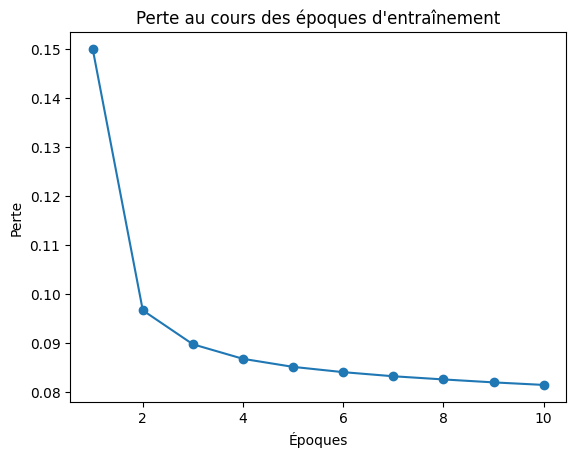

In [ ]:
import matplotlib.pyplot as plt

# Données des époques et des pertes
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
losses = [
    0.1499715902094029,
    0.09668024743854742,
    0.08976407649605649,
    0.08679863916438552,
    0.08515754691493116,
    0.08408326166984323,
    0.0832463295869583,
    0.08259965356272708,
    0.08199808193427144,
    0.08147989060799625,
]

# Tracer les données
plt.plot(epochs, losses, marker="o")

# Ajouter des titres et des étiquettes
plt.title("Perte au cours des époques d'entraînement")
plt.xlabel("Époques")
plt.ylabel("Perte")

# Afficher le graphique
plt.show()


In [113]:
# Evaluation des performances (accuracy, precision, recall, f1-score)
def evaluate_performance(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch)
            predictions = torch.sigmoid(predictions)
            predictions = (predictions > 0.5).int()
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # Save 5% of the rows of the predictions as csv files in the data folder in predictions folder
    np.savetxt(
        "../data/predictions/y_true.csv",
        y_true[: int(0.05 * len(y_true))],
        delimiter=",",
    )
    np.savetxt(
        "../data/predictions/y_pred.csv",
        y_pred[: int(0.05 * len(y_pred))],
        delimiter=",",
    )

    # Accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"Accuracy: {accuracy}")

    # Precision, Recall, F1-Score
    from sklearn.metrics import classification_report

    report = classification_report(y_true, y_pred, digits=4)
    print(report)


In [123]:
# Evaluer les performances pour test_loader combiné avec le train_loader

# Combine les loaders
combined_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([train_dataset, test_dataset]),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

evaluate_performance(model, combined_loader)


Accuracy: 0.9723051520250117
              precision    recall  f1-score   support

           0     0.4464    0.0279    0.0525       897
           1     0.6507    0.3441    0.4502      6155
           2     0.6786    0.0153    0.0299      1242
           3     0.0000    0.0000    0.0000       413
           4     0.6667    0.2975    0.4114       316
           5     0.5431    0.2074    0.3002      1427
           6     0.6324    0.1953    0.2985       599
           7     0.5962    0.0864    0.1510      2511
           8     0.6881    0.1931    0.3016      5142
           9     0.5605    0.1885    0.2821      1130
          10     0.8389    0.6751    0.7482      3734
          11     0.7679    0.6726    0.7171     10338
          12     0.6406    0.3584    0.4596      2193
          13     0.6327    0.1246    0.2081      7081
          14     0.6041    0.1959    0.2958      4534
          15     0.5557    0.2724    0.3656      1832
          16     1.0000    0.0028    0.0056       35

/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/elouarn/Documents/Projet_IA/challenge-data-music-catalogs/music-catalogs-classifier/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Sauvegarder le modèle et les ESNs dans le dossier models et un sous dossier qui s'incrémente
import os
import pickle

# Créer un dossier models s'il n'existe pas
if not os.path.exists("../models"):
    os.makedirs("../models")

# Créer un sous-dossier pour les modèles
sub_folder = 0
while os.path.exists(f"../models/model_{sub_folder}"):
    sub_folder += 1
os.makedirs(f"../models/model_{sub_folder}")

# Sauvegarder le modèle
torch.save(model.state_dict(), f"../models/model_{sub_folder}/transformer.pth")

# Sauvegarder les ESNs
with open(f"../models/model_{sub_folder}/esn_Genre.pkl", "wb") as f:
    pickle.dump(model_Genre, f)

with open(f"../models/model_{sub_folder}/esn_Instrument.pkl", "wb") as f:
    pickle.dump(model_Instrument, f)

with open(f"../models/model_{sub_folder}/esn_Mood.pkl", "wb") as f:
    pickle.dump(model_Mood, f)

print("Transformer et ESNs sauvegardés avec succès !")

Modèle et ESNs sauvegardés avec succès !


In [23]:
# Prédictions
with torch.no_grad():
    sample_input = X_test_tensor[:5]  # Exemple de données
    sample_predictions = model(sample_input)
    predictions_binary = (
        torch.sigmoid(sample_predictions) > 0.5
    ).int()  # Convertir en 0/1
    print("Predictions (binary):", predictions_binary)

Predictions (binary): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32)
